# Galaxies: An interactive graduate course

## Chapter 3: Density fluctuations in the early Universe

#### (c) Benedikt Diemer, University of Maryland

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### 3.2) Describing fluctuations with power spectra and correlation functions

Before diving into the theory of power spectra and random fields, it helps to visualize the meaning of Fourier transforms and power spectra. Let's plot the sine modes that comprise a Fourier decomposition. The modes have $k = 1, 2, 3$ etc, and their amplitude is determined by different power spectra.

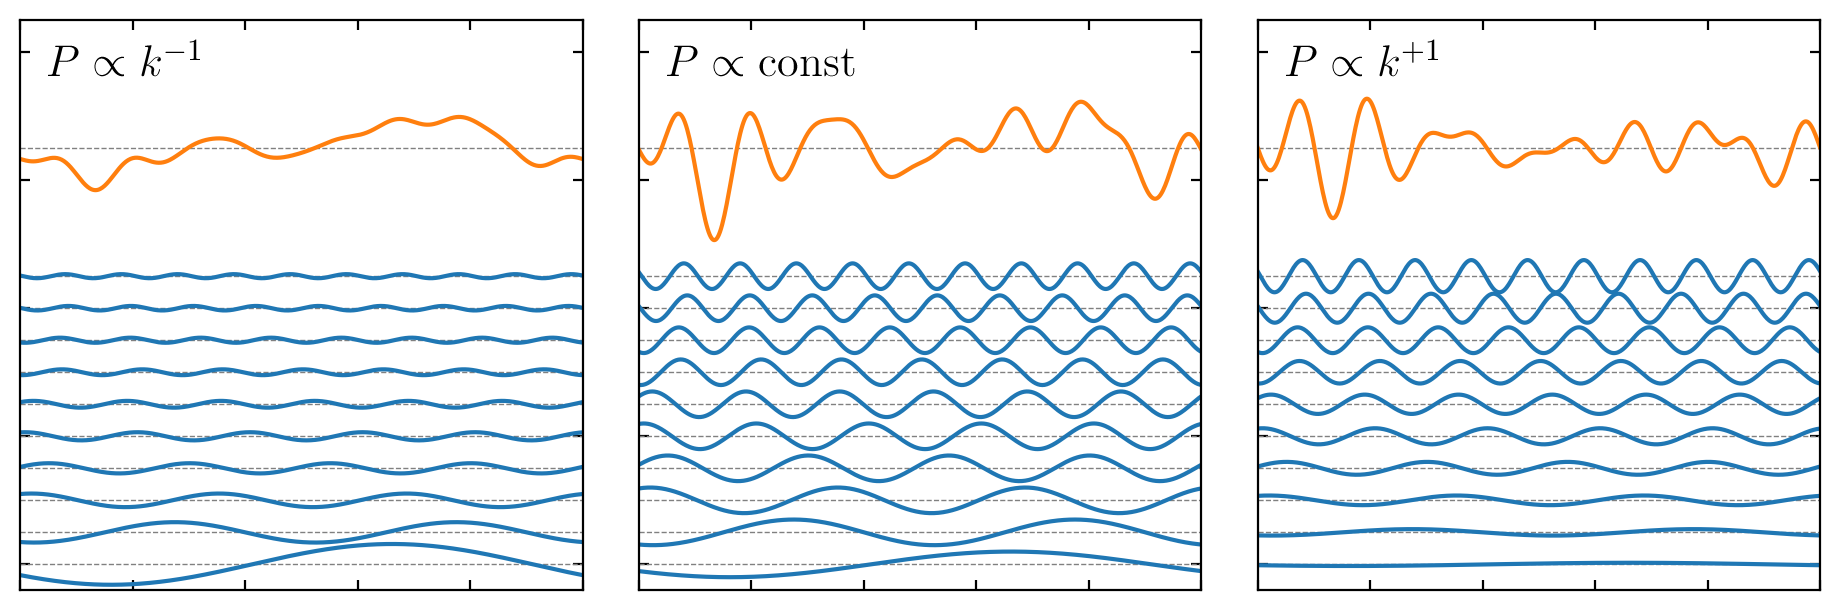

In [2]:
Nk = 10
Nx = 500
space = 2.5

np.random.seed(2024)
phases = np.random.uniform(0.0, 2.0 * np.pi, Nk)
x = np.linspace(0.0, 1.0, Nx)
modes = np.zeros((Nk, Nx), float)

fig, axs = plt.subplots(1, 3, figsize = (12.0, 3.8))
plt.subplots_adjust(wspace = 0.1)

for j in range(3):
    
    for i in range(Nk):
        lam = 1.0 / (i + 1)
        k = 2.0 * np.pi / lam
        if j == 0:
            amp = 10.0 / k
        elif j == 1:
            amp = 1.0
        elif j == 2:
            amp = 0.02 * k
        modes[i] = np.sin(x * k + phases[i]) * amp
    total = np.sum(modes, axis = 0)

    plt.sca(axs[j])
    plt.xlim(0.0, 1.0)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    for i in range(Nk):
        offset = i * space
        plt.axhline(offset, ls = '--', color = 'gray', lw = 0.5)
        plt.plot(x, modes[i] + offset, color = cmn.color_cycle[0])
    offset = (Nk + 3) * space
    plt.axhline(offset, ls = '--', color = 'gray', lw = 0.5)
    plt.plot(x, total + offset, color = cmn.color_cycle[1])
    if j == 0:
        label = r'$P \propto k^{-1}$'
    elif j == 1:
        label = r'$P \propto {\rm const}$'
    elif j == 2:
        label = r'$P \propto k^{+1}$'
    plt.text(0.05, 0.9, label, transform = plt.gca().transAxes, fontsize = 16)
    plt.ylim(-2.0, offset + 10.0)

plt.show()

As expected, we find more large-scale structure if the power spectrum declines with $k$ (left) and more small-scale structure when it increases with $k$ (right). However, the center panel might be surprising in that it looks a lot more like the right than like the left panel. This happens because we can fit more high-$k$ modes than low $k$-modes into our "box." Thus, the variations in the orange line are dominated by high frequencies if the power spectrum is flat.

### 3.3) The linear evolution of fluctuations

#### The linear growth factor

Let's plot the linear growth factor for collisionless perturbations. We plot both the full, numerical solution and the exact solution for matter-radiation Universes.

D+ approaches 1.40 in our LCDM cosmology in the future.


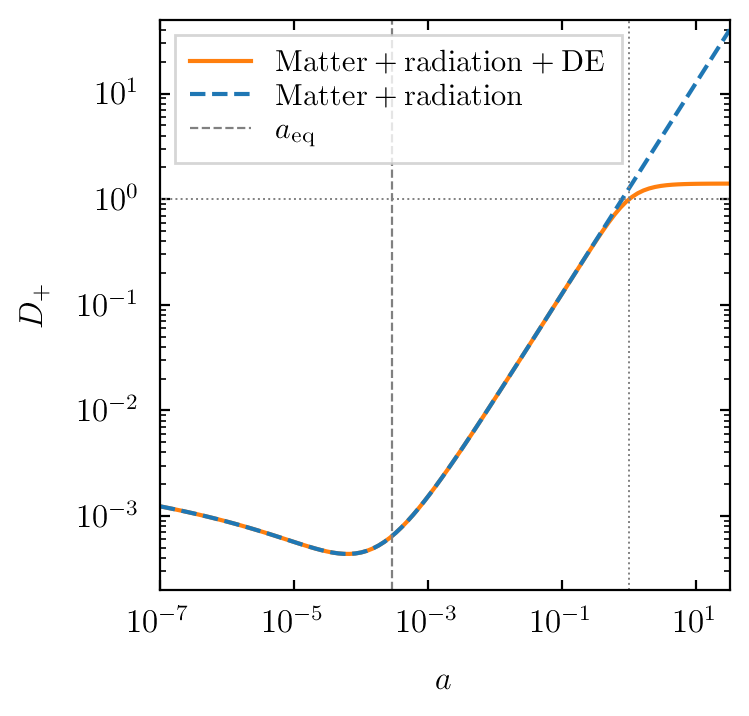

In [3]:
from colossus.cosmology import cosmology

cosmo = cmn.cosmo
h = cosmo.h

# Compute full solution
a = 10**np.linspace(-7.0, 1.5, 100)
z = 1.0 / a - 1.0
D = cosmo._growthFactorExact(z)
print('D+ approaches %.2f in our LCDM cosmology in the future.' % D[-1])

# Compute exact solution
a_eq = cmn.cosmo.a_eq
x = a / a_eq
D_early = a + 2.0 / 3.0 * a_eq + a_eq / (2.0 * np.log(2.0) - 3.0) * (2.0 * np.sqrt(x + 1.0) \
                            + (2.0 / 3.0 + x) * np.log((np.sqrt(1.0 + x) - 1.0) / (np.sqrt(1.0 + x) + 1.0)))
D_early *= D[0] / D_early[0]

# Plot
plt.figure(figsize = (3.8, 3.8))
plt.xlabel(r'$a$')
plt.ylabel(r'$D_+$')
plt.loglog()
plt.xlim(a[0], a[-1])
plt.ylim(2E-4, 50.0)
plt.plot(a, D, lw = 1.5, color = cmn.color_cycle[1], label = r'$\mathrm{Matter + radiation + DE}$')
plt.plot(a, D_early, '--', lw = 1.5, color = cmn.color_cycle[0], label = r'$\mathrm{Matter + radiation}$')
plt.axhline(1.0, ls = ':', color = 'gray', lw = 0.7)
plt.axvline(1.0, ls = ':', color = 'gray', lw = 0.7)
plt.axvline(a_eq, ls = '--', color = 'gray', lw = 0.8, label = r'$a_{\rm eq}$')
plt.legend(frameon = True, labelspacing = 0.2)
plt.show()

#### The Jeans mass

Let's plot the sound speed, Jeans length, and Jeans mass before and after recombination to get a sense of how important this transition is.

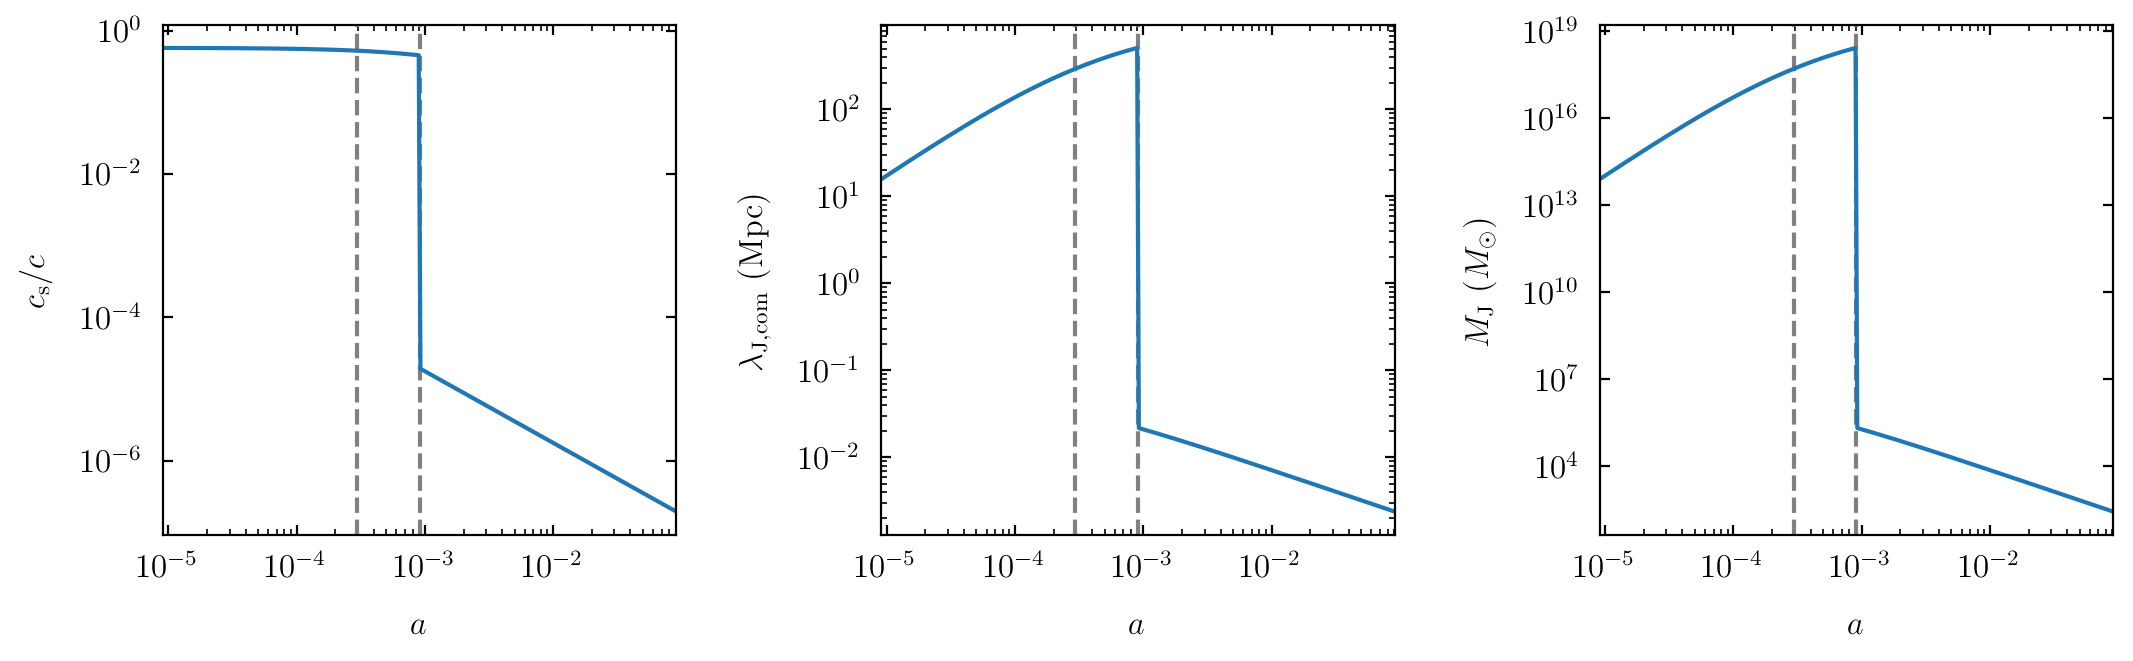

In [4]:
from colossus.utils import constants

z_rec = 1100.0
a_rec = 1.0 / (1.0 + z_rec)
log_a_rec = np.log10(a_rec)
a = 10**np.linspace(log_a_rec - 2.0, log_a_rec + 2.0, 300)
z = 1.0 / a - 1.0
mask_arec = (a > a_rec)
mask_brec = np.logical_not(mask_arec)
cs = np.zeros_like(a)

# Compute baryon-photon sound speed before equality
cgs_density = constants.MSUN * h**2 / constants.KPC**3
rho_g = cosmo.rho_gamma(z) * cgs_density
rho_b = cosmo.rho_b(z) * cgs_density
rho_m = cosmo.rho_m(z) * cgs_density
rho_m_0 = cosmo.rho_m(0.0) * cgs_density
rho_tot = rho_g + rho_m
cs[mask_brec] = constants.C / np.sqrt(3.0) * ((3.0 * rho_b[mask_brec]) / (4.0 * rho_g[mask_brec]) + 1.0)**-0.5

# Compute ideal fluid sound speed after equality. Note that T drops with
# redshift as a^-2, not like photons!
gamma = 5.0 / 3.0
T_bar = cosmo.Tcmb0 / a_rec * (a / a_rec)**-2
P = rho_b * constants.KB * T_bar / (1.22 * constants.M_PROTON)
cs[mask_arec] = np.sqrt(gamma * P[mask_arec] / rho_b[mask_arec])

# Compute Jeans length/mass; here we are using the total density
l_J = cs * np.sqrt(np.pi / constants.G_CGS / rho_tot) / a
M_J = np.pi / 6.0 * rho_m_0 * l_J**3

fig, axs = plt.subplots(1, 3, figsize = (13.0, 3.4))
plt.subplots_adjust(wspace = 0.4)
for i in range(3):
    plt.sca(axs[i])
    plt.xlabel(r'$a$')
    plt.loglog()
    plt.xlim(a[0], a[-1])
    plt.axvline(a_eq, ls = '--', color = 'gray')
    plt.axvline(a_rec, ls = '--', color = 'gray')

plt.sca(axs[0])
plt.ylabel(r'$c_{\rm s} / c$')
plt.plot(a, cs / constants.C)

plt.sca(axs[1])
plt.ylabel(r'$\lambda_{\rm J,com}\ ({\rm Mpc})$')
plt.plot(a, l_J / constants.MPC)

plt.sca(axs[2])
plt.ylabel(r'$M_{\rm J}\ (M_\odot)$')
plt.plot(a, M_J / constants.MSUN)

plt.show()

### 3.4) The power spectrum at recombination

Let's plot the power spectrum at recombination, i.e., when structure formation begins in earnest. Colossus can pull this power spectrum from accurate calculations with CAMB (which needs to be installed, see [website](https://camb.info/)) or from a pretty accurate fitting function by [Eisenstein & Hu 1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...496..605E/abstract). 

Using power spectrum model camb.


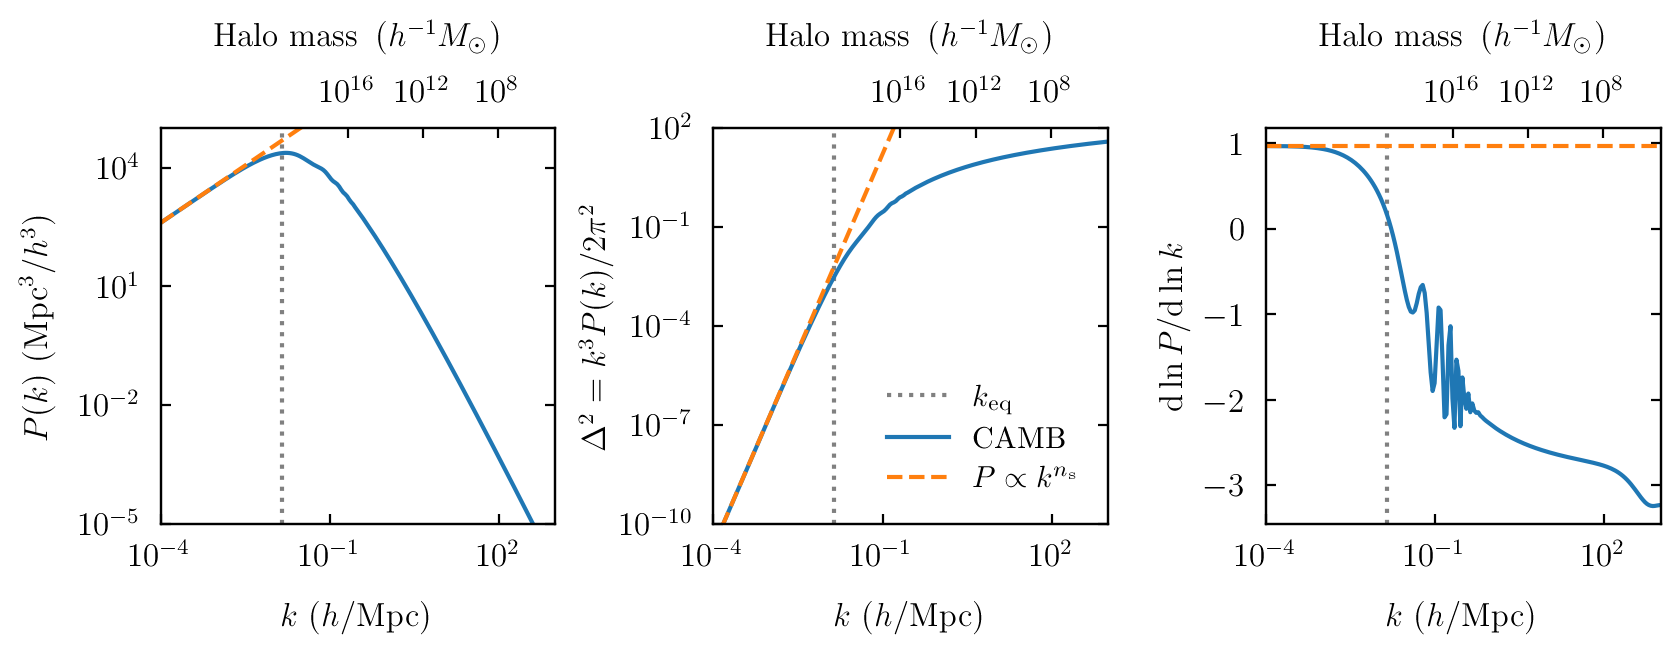

In [5]:
from colossus.lss import peaks

# Check if camb is installed
try:
    import camb
    model = 'camb'
except:
    model = 'eisenstein98'
print('Using power spectrum model %s.' % model)
    
# For comparison, we pull a value for k_eq from the literature (Prada et al. 2018). 
# Computing this number accurately is quite hard in practice because the radiation-only
# assumption breaks down close to radiation-matter equality, by definition.
k_eq_prada = 0.014

# Compute PS
k = 10**np.linspace(-4.0, 3.0, 200)
Pk = cosmo.matterPowerSpectrum(k)
slope = cosmo.matterPowerSpectrum(k, derivative = True, model = model)
Delta2 = k**3 * Pk / (2.0 * np.pi**2)

# Compute inflationary PS normalized to the same amplitude
Pk_inflation = k**cosmo.ns
Pk_inflation *= Pk[0] / Pk_inflation[0]
Delta2_inflation = k**3 * Pk_inflation / (2.0 * np.pi**2)

# Prepare plot
fig, axs = plt.subplots(1, 3, figsize = (10.0, 3.3))
plt.subplots_adjust(wspace = 0.4, top = 0.8)
for i in range(3):
    plt.sca(axs[i])
    plt.xscale('log')
    plt.xlim(k[0], k[-1])
    plt.xlabel(r'$k\ (h / {\rm Mpc})$')

# Plot P(k)
plt.sca(axs[0])
plt.yscale('log')
plt.ylabel(r'$P(k)\ ({\rm Mpc}^3 / h^3)$', labelpad = 8)
plt.axvline(k_eq_prada, ls = ':', color = 'gray')

plt.plot(k, Pk)
plt.plot(k, Pk_inflation, '--')
plt.ylim(1E-5, 1E5)

# Plot Delta^2
plt.sca(axs[1])
plt.yscale('log')
plt.ylabel(r'$\Delta^2 = k^3 P(k) / 2 \pi^2$', labelpad = 2)
plt.axvline(k_eq_prada, ls = ':', color = 'gray', label = r'$k_{\rm eq}$')
plt.plot(k, Delta2, label = r'$\mathrm{CAMB}$')
plt.plot(k, Delta2_inflation, '--', label = r'$P\propto k^{n_{\rm s}}$')
plt.ylim(1E-10, 1E2)

# Plot slope
plt.sca(axs[2])
plt.ylabel(r'${\rm d} \ln P / {\rm d} \ln k$', labelpad = 5)
plt.axvline(k_eq_prada, ls = ':', color = 'gray')
plt.plot(k, slope)
plt.axhline(cosmo.ns, ls = '--', color = cmn.color_cycle[1])

# Second axes with halo mass
logM = np.linspace(4, 16, 4)
M = 10**logM
R = peaks.lagrangianR(M)
k_R = 2.0 * np.pi / R
ticks = []
labels = []
for j in range(len(logM)):
    if k_R[j] > k[0] and k_R[j] < k[-1]:
        ticks.append(k_R[j])
        label = r'$10^{' + str(int(logM[j])) + r'}$'
        labels.append(label)
for i in range(3):
    plt.sca(axs[i])
    ax2 = axs[i].twiny()
    ax2.set_xlabel(r'$\mathrm{Halo\ mass\ }\, (h^{-1}M_{\odot})$', labelpad = 12)
    plt.xscale('log')
    plt.xlim(k[0], k[-1])
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels)
    ax2.set_xticks([], minor = True)

plt.sca(axs[1])
plt.legend()
plt.show()

### 3.5) The initial density field

#### Gaussian random fields

Let's create a Gaussian random field in a 3D cube from an input power spectrum. We could try doing this in 2D to save computation time, but the issue is that the number of modes in $k$-space behaves differently in 2D. In particular, there are only $k^2$ more small-scale modes rather than $k^3$, meaning that the variance is $\propto k^2 P(k)$ rather than $\propto k^3 P(k)$ in 3D, which would lead to noticeably more large-scale structure for the same power spectrum.

In the function implemented in [theory.py](routines/theory.py), we create a Gaussian random field by drawing random numbers with zero mean. We then transform this random field into Fourier space and multiply it with the power spectrum before transforming it back. This operation preserves the Gaussian property but makes sure that the modes receive the appropriate weight.

By creating boxes of different size we can drastically change the appearance. The redshift just scales the growth factor up and down and thus doesn't really matter.

In [6]:
from routines import theory

# Box size in h^{-1} Mpc and grid size
Lbox = 100.0
N = 256
z_ini = 30.0
N_k_bins = 20
np.random.seed(2024)

# Cosmology
cosmo = cmn.cosmo
N3 = N**3

# Compute grid in delta and delta_k
k, delta, delta_k, D = theory.gaussianRandomField(Lbox, N, z_ini, cosmo.matterPowerSpectrum)

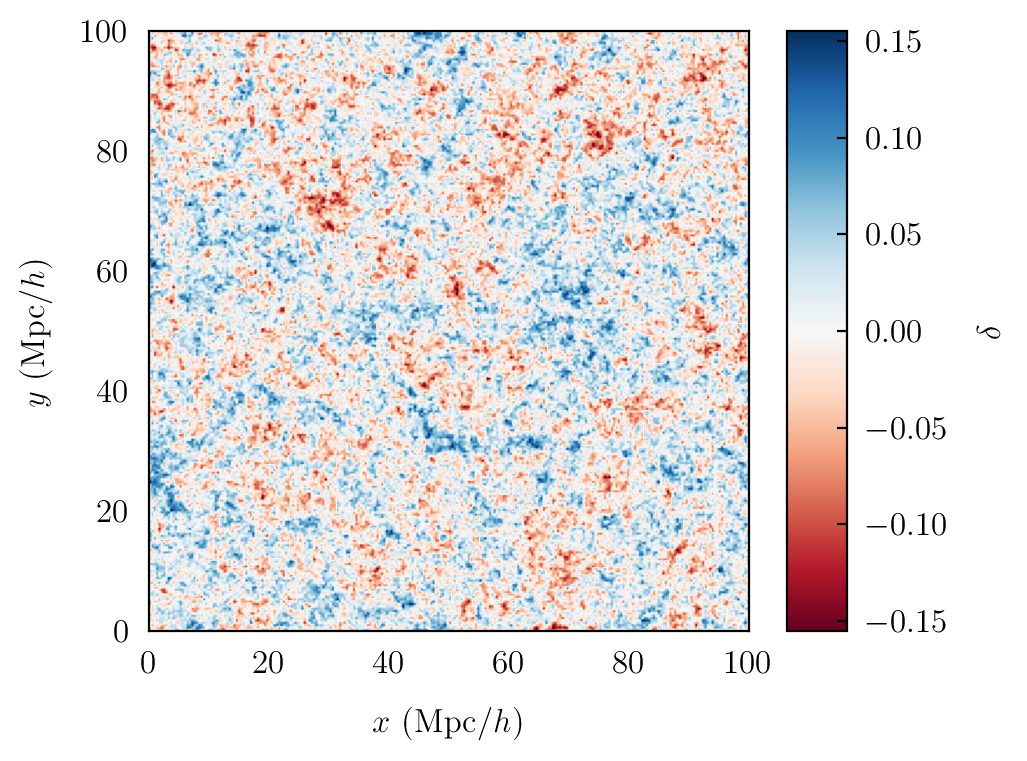

In [7]:
# Plot a slice through the box
N_half = int(N / 2)
delta_slice = delta[:, :, N_half]
max_ext = max(np.max(delta_slice), np.abs(np.min(delta_slice))) * 0.8

plt.figure(figsize = (5.0, 5.0))
plt.xlabel(r'$x\ ({\rm Mpc} / h)$')
plt.ylabel(r'$y\ ({\rm Mpc} / h)$')
plt.gca().tick_params('both', length = 0)
im = plt.imshow(delta_slice, cmap = 'RdBu', vmin = -max_ext, vmax = max_ext, extent = (0.0, Lbox, 0.0, Lbox))
cbar = plt.colorbar(im, ax = plt.gca(), shrink = 0.8, pad = 0.05, aspect = 10)
cbar.set_label(r'$\delta$')
plt.show()

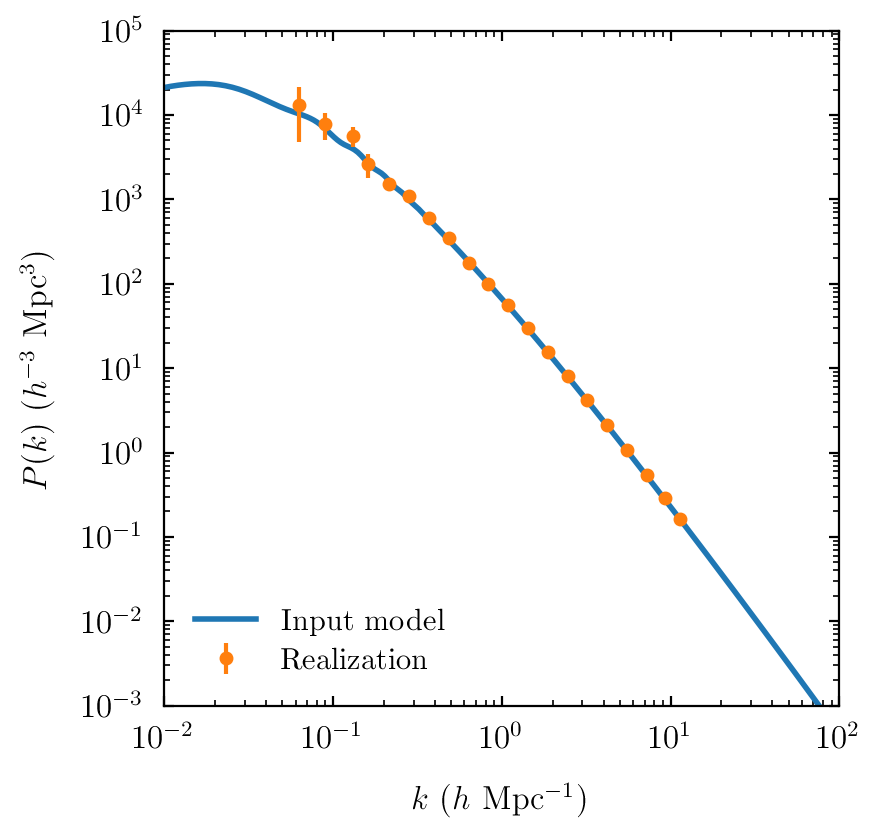

In [8]:
# Let's compute and check P(k) from the randomly created Fourier grid. We do this in 
# some number N_k_bins in log10(k) space, where k runs from the smallest to the 
# largest modes present in our grid. Note that the highest k's are set by the box 
# size and N. P(k) = <|delta_k|^2>, so we take a histogram of k weighted by the 
# coefficients delta_k and then divide by the number of modes in each k bin, as well
# as the linear growth factor (since we are comparing to the PS at z = 0) and N^3.
log_k = np.log10(k)
D2 = D**2
Pk_j, _ = np.histogram(log_k, bins = N_k_bins, weights = np.square(np.abs(delta_k)), density = False) 
N_modes_j, _  = np.histogram(log_k, bins = N_k_bins, density = False) 
Pk_j = Pk_j / N_modes_j / D2 / N3

# We plot not at the bin centers but at the position in k space that corresponds to
# the average of the modes. Since there are more high-k modes, this shifts the points.
log_k_j, _ = np.histogram(log_k, bins = N_k_bins, weights = log_k, density = False) 
log_k_j /= N_modes_j
k_j = 10.0**log_k_j

# We also want to compute the uncertainty on our measured P(k) to make sure that 
# differences to the input P(k) are within statistical expectations. This can be 
# computed from the square of the square of the Fourier modes, as in the error 
# is <x^2> - <x>^2 basically.
Pk2_j, _ = np.histogram(log_k, bins = N_k_bins, weights = np.abs(delta_k)**4, density = False) 
Pk2_j /= D2**2 * N3**2
Pk_err_j = np.sqrt(Pk2_j / (N_modes_j * (N_modes_j - 1)) - Pk_j**2 / (N_modes_j - 1))

# We also plot the input model for comparison
log_k_plot = np.linspace(-2.0, 2.0, 200)
k_plot = 10.0**log_k_plot
Pk_plot = cosmo.matterPowerSpectrum(k_plot)

# Plot
plt.figure()
plt.loglog()
plt.xlabel(r'$k\ (h\rm\ Mpc^{-1})$')
plt.ylabel(r'$P(k)\ (h^{-3}\ \rm Mpc^3)$')
plt.xlim(1E-2, 1E2)
plt.ylim(1E-3, 1E5)

plt.plot(k_plot, Pk_plot, lw = 2.0, label = r'$\mathrm{Input\ model}$')
plt.errorbar(k_j, Pk_j, yerr = 2.0 * Pk_err_j, fmt = 'o', markersize = 4.0, label = r'$\mathrm{Realization}$')

plt.legend(loc = 3)
plt.show()

#### Testing different power spectra

We start by defining a set of different power spectra to test.

In [9]:
from colossus.cosmology import cosmology

# Pk without BAO; makes very little difference on this plot and is thus not used

def powerSpectrumZeroBaryon(k):

    return cmn.cosmo.matterPowerSpectrum(k, model = 'eisenstein98_zb')

# Power spectrum for warm dark matter according to Equation 3 in Lovell et al. 2014.
# This is an approximate formula for the effects of WDM. The wavenumber where the 
# effect starts to be noticeable is about k ~ 1 / 3 alpha. 

def powerSpectrumWarmDM(k, wdm_mass = 0.2):

    wdm_nu = 1.0
    wdm_g = 1.5
    
    cosmo = cmn.cosmo
    P = cosmo.matterPowerSpectrum(k)
    alpha = 0.05 * wdm_mass**-1.15 * (cosmo.Om0 / 0.4)**0.15 * (cosmo.h / 0.65)**1.3 * (wdm_g / 1.5)**-0.29
    T = (1.0 + (alpha * k)**(2.0 * wdm_nu))**-(5.0 / wdm_nu)
    P *= T**2

    return P

# A weird power spectrum with two peaks at certain wave modes

def powerSpectrumPeaks(k):

    log_k1 = 0.2
    log_k2 = -0.7
    sigma1 = 0.02
    sigma2 = 0.02
    norm1 = 5.0
    norm2 = 4000.0
    
    log_k = np.log10(k)
    
    g1 = norm1 * np.exp(-0.5 * ((log_k - log_k1) / sigma1)**2) / (sigma1 * np.sqrt(2.0 * np.pi))
    g2 = norm2 * np.exp(-0.5 * ((log_k - log_k2) / sigma2)**2) / (sigma2 * np.sqrt(2.0 * np.pi))
    
    return g1 + g2

def getPowerSpectrum(i):
    
    kwargs = {}
    if i == 0:
        cosmo_ = cosmology.setCosmology('powerlaw_-1.3')
        Pk_func = cosmo_.matterPowerSpectrum
        label = r'$P \propto k^{-1.3}$'
    elif i == 1:
        cosmo_ = cosmology.setCosmology('powerlaw_-1.8')
        Pk_func = cosmo_.matterPowerSpectrum
        label = r'$P \propto k^{-1.8}$'
    elif i == 2:
        cosmo_ = cosmology.setCosmology('powerlaw_-2.3')
        Pk_func = cosmo_.matterPowerSpectrum
        label = r'$P \propto k^{-2.3}$'
    elif i == 3:
        cosmo_ = cosmology.setCosmology('powerlaw_-2.8')
        Pk_func = cosmo_.matterPowerSpectrum
        label = r'$P \propto k^{-2.8}$'
    elif i == 4:
        cosmology.setCurrent(cmn.cosmo)
        Pk_func = cmn.cosmo.matterPowerSpectrum
        label = r'$\mathrm{Planck\ 2018}$'
    elif i == 5:
        Pk_func = powerSpectrumWarmDM
        kwargs['wdm_mass'] = 0.4
        label = r'$\mathrm{Warm\ DM}$'
    elif i == 6:
        Pk_func = powerSpectrumWarmDM
        kwargs['wdm_mass'] = 0.1
        label = r'$\mathrm{Hot\ DM}$'
    elif i == 7:
        Pk_func = powerSpectrumPeaks
        label = r'$\mathrm{Peaks}$'
    else:
        raise Exception('No power spectrum defined.')

    return Pk_func, label, kwargs

Let's plot those power spectra and their density fields. Note that the ones created by Colossus cosmologies are already normalized to the $\sigma_8$ set in the respective cosmologies, which are all $\sim 0.8$.

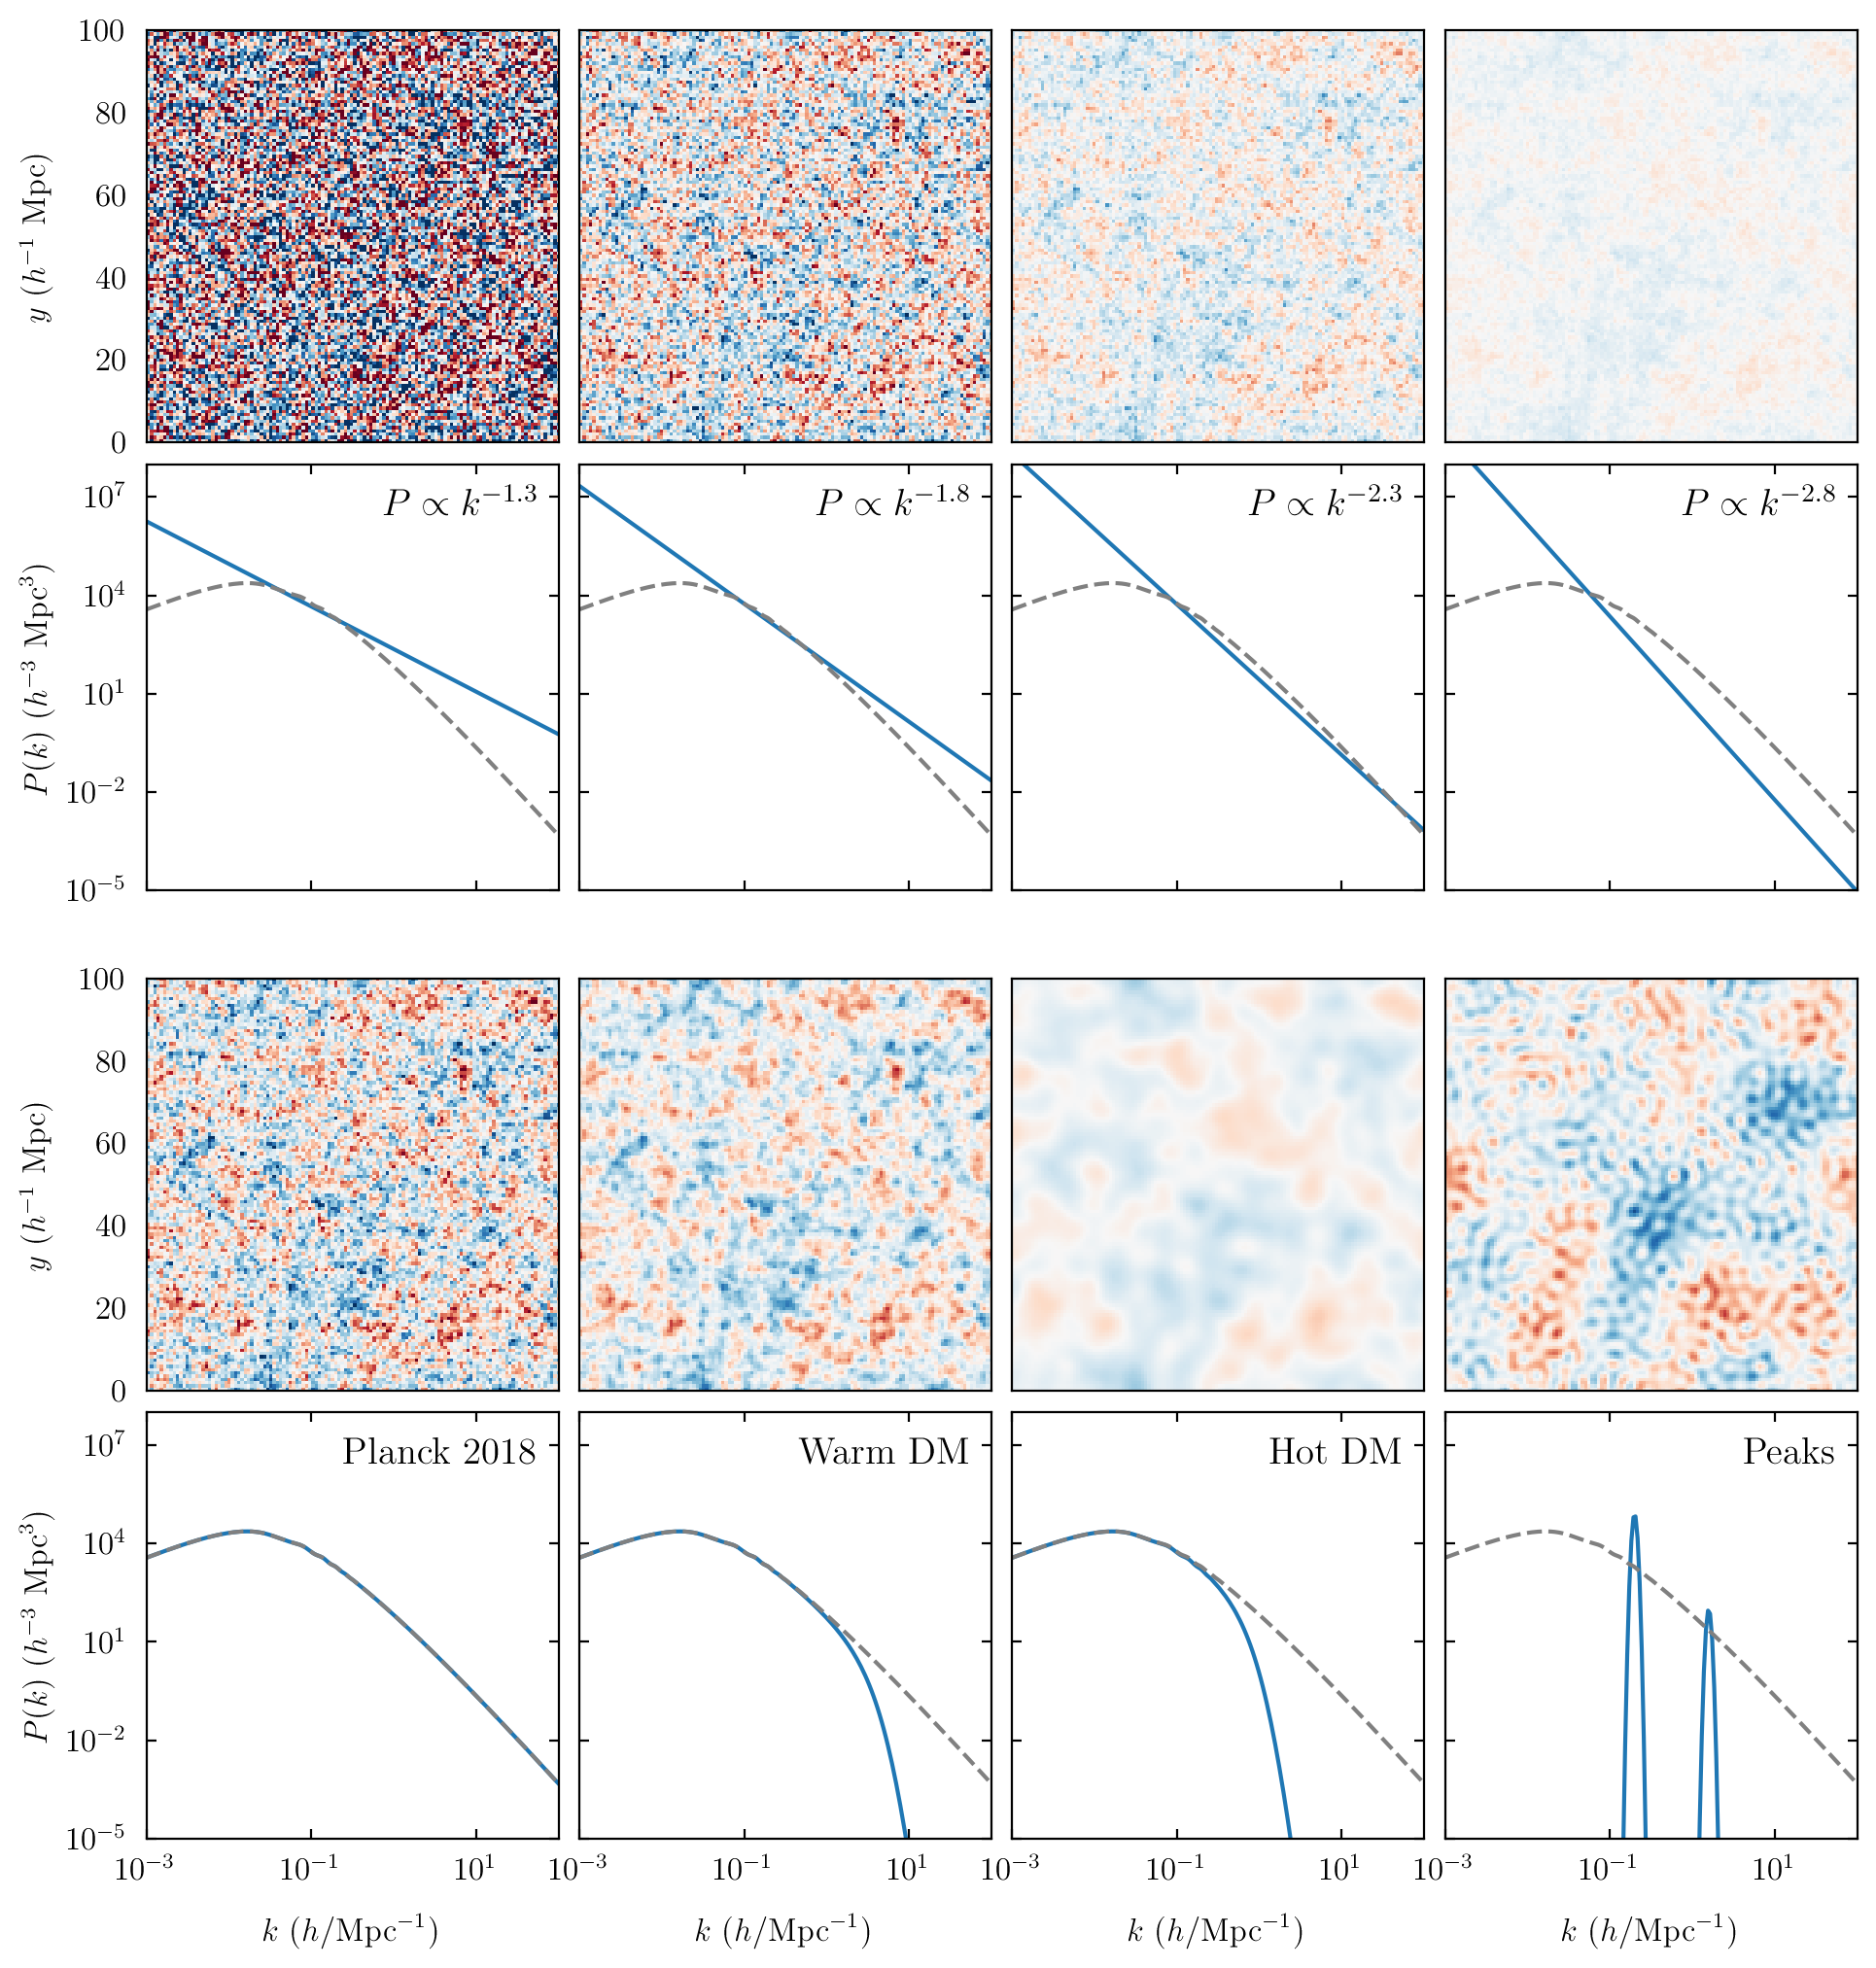

In [10]:
# Settings for Pk plots
n_rows = 2
n_cols = 4
log_k_plot = np.linspace(-3.0, 2.0, 200)

# Settings for density field plots
Lbox = 100.0
N = 128
vmax = 0.3
random_seed = 2024

n_tot = n_rows * n_cols
N_half = int(N / 2)
k_plot = 10.0**log_k_plot

fig, axs = plt.subplots(n_rows * 3, n_cols, figsize = (10.0, 11.0), height_ratios = [2.5, 2.5, 0.3] * 2)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.98, top = 0.98, hspace = 0.05, wspace = 0.05)

for i in range(n_rows):
    for j in range(n_cols):

        # Select power spectrum function
        i_tot = n_cols * i + j
        Pk_func, label, kwargs = getPowerSpectrum(i_tot)
        
        # Create Density field panel
        ax = axs[i * 3][j]
        plt.sca(ax)
        ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])
        else:
            plt.ylabel(r'$y\ (h^{-1}\ {\rm Mpc})$')
        ax.tick_params('both', length = 0)

        # Create density field. We re-set the same random seed each time so that we get
        # the same random modes, and thus the same large-scale structure
        np.random.seed(random_seed)
        k, delta, delta_k, D = theory.gaussianRandomField(Lbox, N, z_ini, Pk_func, **kwargs)
        delta_slice = delta[:, :, N_half]
        im = plt.imshow(delta_slice, cmap = 'RdBu', vmin = -vmax, vmax = vmax, extent = (0.0, Lbox, 0.0, Lbox))
        
        # Create power spectrum panel
        ax = axs[i * 3 + 1][j]
        plt.sca(ax)
        plt.loglog()
        plt.xlim(k_plot[0], k_plot[-1])
        plt.ylim(1E-5, 1E8)
        if j > 0:
            ax.set_yticklabels([])
        else:
            plt.ylabel(r'$P(k)\ (h^{-3}\ {\rm Mpc}^3)$', labelpad = 4)
        if i < n_rows - 1:
            ax.set_xticklabels([])
        else:
            plt.xlabel(r'$k\ (h / {\rm Mpc}^{-1})$')

        # Plot power spectrum
        Pk_plot = Pk_func(k_plot, **kwargs)
        plt.plot(k_plot, Pk_plot)

        # Always compare to our standard LCDM power spectrum
        Pk_lcdm = cmn.cosmo.matterPowerSpectrum(k_plot)
        plt.plot(k_plot, Pk_lcdm, ls = '--', color = 'gray')
        
        # Label
        plt.text(0.95, 0.88, label, transform = ax.transAxes, fontsize = 14, ha = 'right')

        # Empty third panel to create space for Pk x-labels
        ax = axs[i * 3 + 2][j]
        ax.set_axis_off()

plt.show()

#### The smoothed density field

When we smooth the density field, we almost always use a tophat or Gaussian filter. Mathematically, we multiply those filters with the density field in Fourier space.

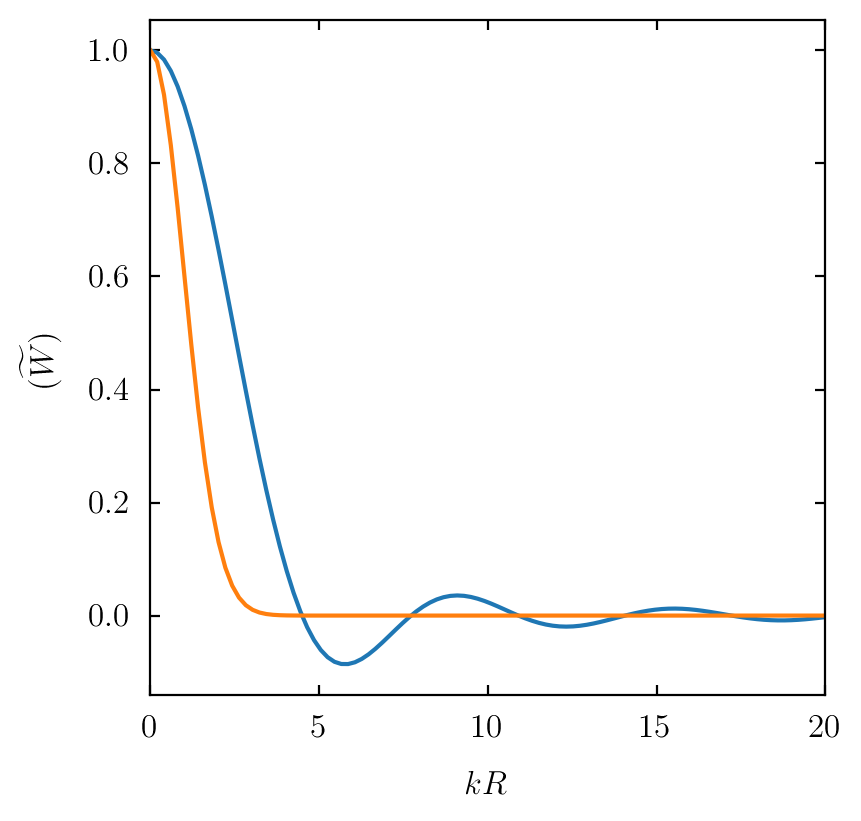

In [11]:
kR = np.linspace(1E-5, 20.0, 100)

plt.figure()
plt.xlabel(r'$kR$')
plt.ylabel(r'$(\widetilde{W})$')
plt.xlim(0.0, kR[-1])

f = theory.filterFourierSpace(kR, filt = 'tophat')
plt.plot(kR, f, label = r'$\mathrm{Tophat}$')

f = theory.filterFourierSpace(kR, filt = 'gaussian')
plt.plot(kR, f, label = r'$\mathrm{Gaussian}$')

plt.show()

While the tophat filter is compact in real space in the sense that it is zero outside of $R$, it has infinite extent in Fourier space and oscillates. Let's plot some smoothed fields.

In [12]:
Lbox = 100.0
N = 256
z_ini = 30.0

cosmo = cmn.cosmo
k, delta, delta_k, D = theory.gaussianRandomField(Lbox, N, z_ini, cosmo.matterPowerSpectrum)

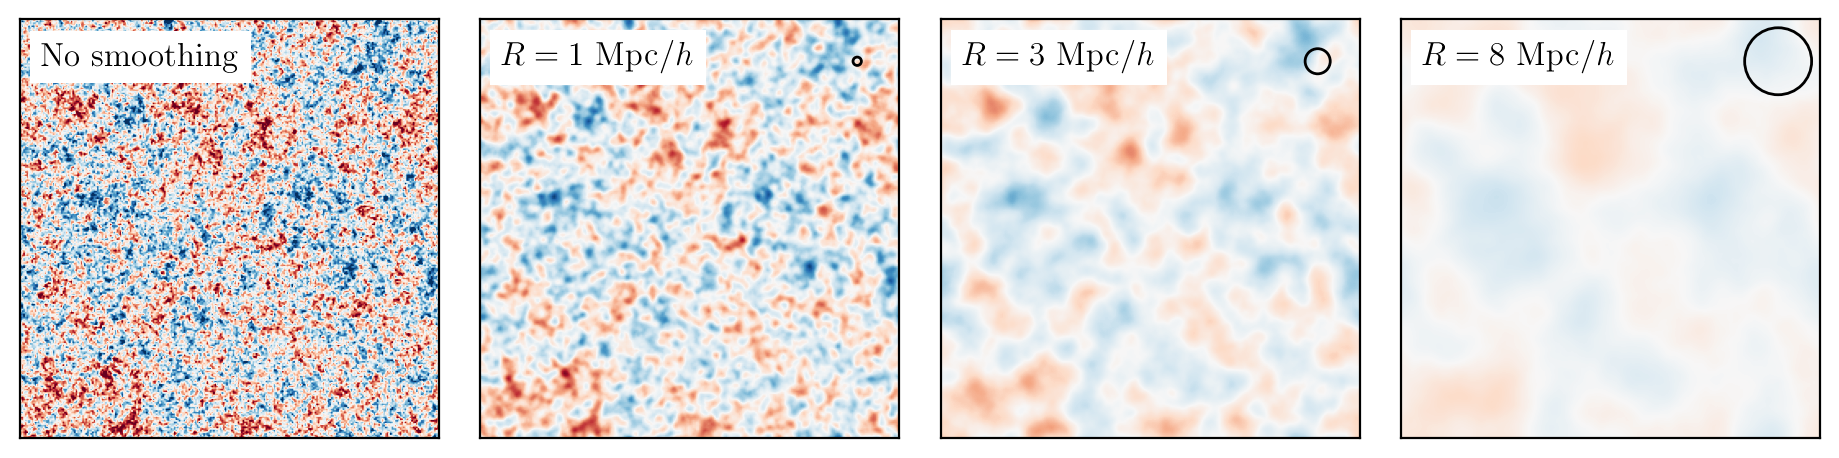

In [13]:
import matplotlib as mpl

Rf_array = [0.0, 1, 3, 8]
filt = 'tophat'
max_ext = 0.1

n_R = len(Rf_array)
fig, axs = plt.subplots(1, n_R, figsize = (12.0, 4.0))
plt.subplots_adjust(wspace = 0.1)

for i in range(n_R):
    
    # Compute smoothed field. We multiply the smoothing filter in Fourier space and 
    # transform back into real space.
    Rf = Rf_array[i]
    if Rf > 0.0:
        kR = k * Rf 
        delta_smooth = np.fft.fftn(delta) * theory.filterFourierSpace(kR, filt)
        delta_smooth = np.real(np.fft.ifftn(delta_smooth))
        label = r'$R = %s\ {\rm Mpc}/h$' % str(Rf)
    else:
        delta_smooth = delta
        label = r'$\mathrm{No\ smoothing}$'
    delta_slice = delta_smooth[:, :, N_half]
    
    # Plot
    ax = axs[i]
    plt.sca(ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params('both', length = 0)
    plt.imshow(delta_slice, cmap = 'RdBu', vmin = -max_ext, vmax = max_ext, extent = (0.0, Lbox, 0.0, Lbox))
    plt.text(0.05, 0.89, label, transform = ax.transAxes, fontsize = 12, bbox = dict(fc = 'w', lw = 0))
    if Rf > 0.0:
        ax.add_artist(mpl.patches.Circle((Lbox * 0.9, Lbox * 0.9), Rf, color = 'k', fill = False))
plt.show()

The maps now show us the smoothed density, that is, the average over- or underdensity within a sphere of radius $R_{\rm f}$ around each point.

#### Cosmic variance

Let's see how much variance we expect between randomly placed spheres of radius $R$ using the tophat filter. This integral is already implemented in Colossus.

0.812353061454295 0.8102


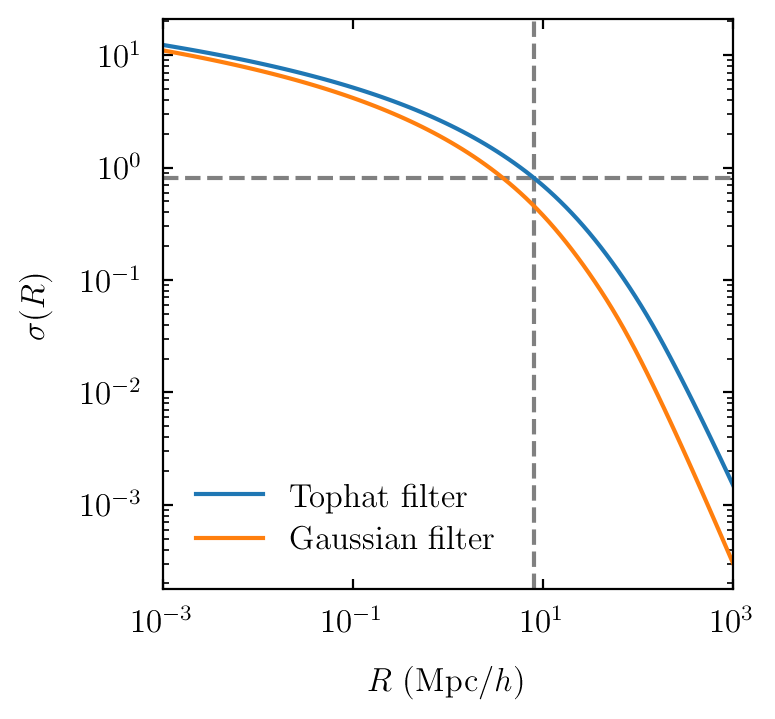

In [14]:
R_plot = 10**np.linspace(-3.0, 3.0, 100)
sigma_tophat = cmn.cosmo.sigma(R_plot)
sigma_gaussian = cmn.cosmo.sigma(R_plot, filt = 'gaussian')
sigma8 = np.interp(8.0, R_plot, sigma_tophat)
print(sigma8, cmn.cosmo.sigma8)

plt.figure(figsize = (3.8, 3.8))
plt.loglog()
plt.xlim(R_plot[0], R_plot[-1])
plt.xlabel(r'$R\ ({\rm Mpc} / h)$')
plt.ylabel(r'$\sigma(R)$')
plt.axvline(8.0, ls = '--', color = 'gray')
plt.axhline(sigma8, ls = '--', color = 'gray')
plt.plot(R_plot, sigma_tophat, label = r'$\mathrm{Tophat\ filter}$')
plt.plot(R_plot, sigma_gaussian, label = r'$\mathrm{Gaussian\ filter}$')
plt.legend(fontsize = 12)
plt.show()

The power spectrum is normalized so that $\sigma(8\ {\rm Mpc} / h) = \sigma_8 \approx 0.82$ in our cosmology. At Gpc scales, the variance becomes small, about $10^{-1}$. This is simply a statement of the homogeneity of the Universe on large scales. At small scales, the variance keeps increasing. We can try to integrate across the entire power spectrum:

In [15]:
import scipy.integrate

def integrand(k):
    
    return k**2 * cmn.cosmo.matterPowerSpectrum(k)

sigma2, _ = scipy.integrate.quad(integrand, 1E-12, 1E11)
sigma0 = np.sqrt(sigma2 * 1.0 / (2.0 * np.pi**2))
print(sigma0)

47.2108858656425


However, the value depends quite a bit on the upper integration limit in $k$-space (which, in our specific calculation, is set by Colossus's interpolation tables). This tells us that the variance is still dominated by smaller and smaller scales, which is not really physical since small scales are a) affected by baryons and b) the power spectrum probably does not extend all the way to such small scales without drastic modifications, e.g., from the DM having some thermal motions. We conclude that the total variance of the matter field is not a well-defined quantity.